# 0.0. IMPORTS

In [2]:
import pandas              as pd
import matplotlib.pyplot   as plt
import pandas.util.testing as tm
import statsmodels.api     as sm
import numpy               as np
import warnings

from pandas                        import DataFrame
from pandas                        import Grouper
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools     import adfuller
from sklearn.metrics               import mean_squared_error
from math                          import sqrt
from statsmodels.tsa.arima_model   import ARIMA
from statsmodels.tsa.seasonal      import seasonal_decompose
from fbprophet                     import Prophet
from sklearn.metrics               import mean_absolute_error,mean_squared_error
from sklearn.metrics               import r2_score


warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 0.1. Help Functions

In [3]:
# Cria a função que faz a diferenciação
def difference( dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff


# Cria a função que reverte o valor diferenciado para o original
def inverse_difference( history, previsao, interval=1):
  return previsao + history[-interval]


# Cria a função que executa o modelo arima
def evaluate_arima_model(X, arima_order):
  # Converte o conjunto de dados
  X = X.astype('float32')
  # Separa os dados com 50% dos dados para treino e 50% para teste 
  train_size = int(len(X) * 0.50)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train] 
  # Cria a lista de previsões
  predictions = list()
  for t in range(len(test)):
    # Aplica diferenciação nos dados
    months_in_year = 12
    diff = difference(history, months_in_year)
    # Treina o modelo ARIMA
    model = ARIMA(diff, order=arima_order)
    model_fit = model.fit(trend='nc', disp=0)
    # Recebe os dados previtos pelo modelo
    valor_previsto = model_fit.forecast()[0]
    valor_previsto = inverse_difference(history, valor_previsto, months_in_year)
    # Adiciona os dados na lista de previsões
    predictions.append(valor_previsto)
    history.append(test[t])
  # Calculate o erro rmse
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse


# Loop com combinações de p, d e q para o modelo ARIMA
def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None
  # Intera sobre todos os valores de p
  for p in p_values:
    # Intera sobre todos os valores de d
    for d in d_values:
      # Intera sobre todos os valoes de q
      for q in q_values:
        order = (p,d,q)
        try:
          # Chama a funcão que executa o ARIMA
          rmse = evaluate_arima_model(dataset, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print('ARIMA%s RMSE=%.3f' % (order,rmse))
        except:
          continue 
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


# Função que calcula as métricas do modelo
def ml_error(model_name,y,yhat):

  mae=mean_absolute_error(y,yhat)
  mape=np.mean(np.abs((y-yhat)/y))
  rmse=np.sqrt(mean_squared_error(y,yhat))
  r2score=r2_score(y,yhat)

  return pd.DataFrame({    'Model Name':  model_name,
                           'MAE':         mae,
                           'MAPE':        mape,
                           'RMSE':        rmse  ,
                           'R2-SCORE':    r2score     },index=[0])

## 0.2. Loading Data

In [4]:
series=pd.read_csv('/content/champagne_sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
series.head()

Month
1964-01-01    2815
1964-02-01    2672
1964-03-01    2755
1964-04-01    2721
1964-05-01    2946
Name: Sales, dtype: int64

## 0.3. Separando os dados em Treino, Teste e Validação.

In [5]:
# Separando os dados por meses
split_point= len(series) - 12

# Dataset vai conter linhas até o split_point
dataset=series[0:split_point]

# Validation terá dados do split_point em diante
validation= series[split_point:]

# Imprime o tamanho dos conjuntos
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

Dataset 93, Validation 12


# 1.0. DESCRIPTION OF THE DATA

## 1.1. Estatística descritíva

In [6]:
series.describe()

count     105.00
mean     4761.15
std      2553.50
min      1413.00
25%      3113.00
50%      4217.00
75%      5221.00
max     13916.00
Name: Sales, dtype: float64

## 1.2. Dados no tempo

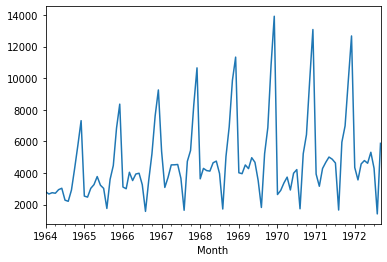

In [7]:
series.plot()

## 1.3. Visualizando a sazonalidade

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d7bb73850>,
      dtype=object)

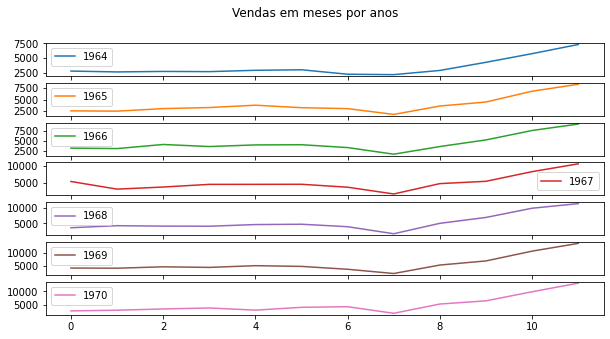

In [8]:
grupos = series['1964':'1970'].groupby(Grouper(freq='A'))
anos = DataFrame()

for nome, grupo in grupos:
  anos[nome.year] = grupo.values

anos.plot( figsize=(10,5),
           subplots=True,
           title='Vendas em meses por anos')

## 1.4. Distribuição da série

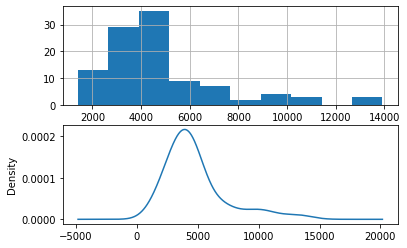

In [9]:
plt.figure(1)
plt.subplot(211)
series.hist()
plt.subplot(212)
series.plot(kind='kde')
plt.show()

## 1.5. Visualizando a Autocorrelação

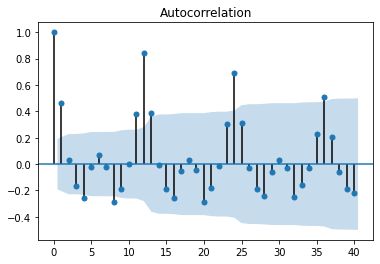

In [10]:
plot_acf(series, lags=40)
plt.show()

## 1.6. Checando Estacionalidade

In [11]:
resultado= adfuller(series.values)
print('\nADF teste: %f' % resultado[0])
print('\np-value: %f' % resultado[1])
print('\nCritical Values: ')
for key, value in resultado[4].items():
  print('\t%s: %.3f' % (key, value))


ADF teste: -1.833593

p-value: 0.363916

Critical Values: 
	1%: -3.503
	5%: -2.893
	10%: -2.584


# 2.0. DATA PREPARATION

In [12]:
# Atribuindo os dados a variável X
X = series.values

# Definindo o tamanho do dataset de treino e teste
train_size= int(len(X) * 0.50)

# Cria os conjuntos de treino e teste
train= X[0: train_size]
test= X[train_size:]

# 3.0. MACHINE LEARNING MODELLING

## 3.1. BaseLine

In [13]:
# Obtendo todos os dados de treino
history= [x for x in train]

# Criando a lista de previsões
predictions= list()

# Aplicando o BaseLine
for i in range(len(test)):

  # valor_predito recebe o último valor do conjunto de treino
  valor_predito = history[-1]

  # A primeira previsão é o último valor do conjunto de treino
  predictions.append(valor_predito)

  # Valor real recebe o valor atual do teste
  valor_real = test[i]

  # Adiciona o valor real para a lista de historico
  history.append(valor_real)

# Performance
baseline_results=ml_error('BaseLine',test, predictions)
baseline_results

,Model Name,MAE,MAPE,RMSE,R2-SCORE
0,BaseLine,2100.83,0.53,3167.36,-0.19


## 3.2. ARIMA

In [14]:
# Cria a variável history
history = [x for x in train]

# Cria lista de previsões
predictions = list()

# Inicia Walk-Forward
for t in range(len(test)):

  # Difference data
  meses_no_ano = 12
  diff = difference(history, meses_no_ano)

  # Cria um modelo ARIMA com os dados de history
  model = ARIMA(diff, order=(1,1,1))

  # Treina o modelo ARIMA
  model_fit = model.fit(trend='nc', disp=0)

  # A variável valor_predito recebe o valor previsto pelo modelo
  valor_predito = model_fit.forecast()[0]

  # valor_predito recebe o valor revertido (escala original)
  valor_predito = inverse_difference(history, valor_predito, meses_no_ano)

  # Adiciona o valor predito na lista de predições
  predictions.append(valor_predito)

  # A variável valor_real recebe o valor real do teste
  valor_real = test[t]

  # Adiciona o valor real a variável history
  history.append(valor_real)

# Performance
arima_results=ml_error('ARIMA',test, predictions)
arima_results

,Model Name,MAE,MAPE,RMSE,R2-SCORE
0,ARIMA,619.71,0.67,840.27,0.92


## 3.3. SARIMA

In [15]:
# Cria a variável history
history = [x for x in train]

# Cria lista de previsões
predictions = list()

# Inicia Walk-Forward
for t in range(len(test)):
  
  # Difference data
  meses_no_ano = 12

  # Cria um modelo SARIMA com os dados de history
  # Desliga a diferenciação do modelo ARIMA
  model = sm.tsa.statespace.SARIMAX(history, order=(1,0,1), seasonal_order=(1,1,1, meses_no_ano))
  
  # Treina o modelo SARIMAX
  model_fit = model.fit(trend='nc', disp=0)
  
  # A variável valor_predito recebe o valor previsto pelo modelo
  valor_predito = model_fit.forecast()[0]
 
  # Adiciona o valor predito na lista de predicões
  predictions.append(valor_predito)

  # A variável valor_real recebe o valor real do teste
  valor_real = test[t]
  
  # Adiciona o valor real a variável history
  history.append(valor_real)

# Performance
sarima_results=ml_error('SARIMA',test, predictions)
sarima_results

,Model Name,MAE,MAPE,RMSE,R2-SCORE
0,SARIMA,598.98,0.14,784.08,0.93


## 3.4. Facebook Prophet

In [16]:
# ds: features temporais
# y: valores a serem preditos

dataframe = pd.DataFrame({'ds': dataset.index, 'y': dataset.values})

# Instancia o objeto prophet
model = Prophet()

# Gerando o modelo
model.fit(dataframe)

# Gerando dados futuros
futuro = model.make_future_dataframe(periods = 12, freq='M')

# Prevendo valores para dados futuros
saida = model.predict(futuro)

# Dataset de validação
validation_df = pd.DataFrame({'ds': validation.index})

# Aplicando o modelo do prophet
saida = model.predict(validation_df)

# Performance
fbp_results=ml_error('FBPROPHET',validation.values, saida.yhat)
fbp_results

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,Model Name,MAE,MAPE,RMSE,R2-SCORE
0,FBPROPHET,600.74,0.19,754.08,0.93


## 3.5. Compare Model's Performances

In [ ]:
models_results=pd.concat([baseline_results,arima_results,sarima_results,fbp_results])
models_results.sort_values('RMSE')

# 4.0. HYPERPARAMETERS FINE TUNING

In [20]:
# Definindo a lista de valores para cada parãmetro
p_values=  range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)

In [21]:
# Chama a função passando os parâmetros
evaluate_models( series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=785.401
ARIMA(0, 0, 2) RMSE=808.652
ARIMA(0, 0, 3) RMSE=818.649
ARIMA(0, 0, 4) RMSE=826.024
ARIMA(0, 0, 5) RMSE=857.593
ARIMA(0, 0, 6) RMSE=982.026
ARIMA(0, 1, 1) RMSE=842.231
ARIMA(0, 2, 1) RMSE=913.984
Best ARIMA(0, 0, 1) RMSE=785.401
ARIMA(1, 0, 0) RMSE=781.498
ARIMA(1, 1, 0) RMSE=897.585
ARIMA(1, 1, 1) RMSE=840.267
ARIMA(1, 2, 0) RMSE=1238.544
Best ARIMA(1, 0, 0) RMSE=781.498
ARIMA(2, 0, 0) RMSE=799.813
ARIMA(2, 0, 1) RMSE=834.320
ARIMA(2, 1, 0) RMSE=911.722
ARIMA(2, 1, 1) RMSE=866.863
ARIMA(2, 2, 0) RMSE=1196.109
ARIMA(2, 2, 1) RMSE=918.762
Best ARIMA(1, 0, 0) RMSE=781.498
ARIMA(3, 0, 0) RMSE=838.806
ARIMA(3, 1, 0) RMSE=903.022
ARIMA(3, 1, 1) RMSE=872.366
ARIMA(3, 2, 0) RMSE=1084.343
Best ARIMA(1, 0, 0) RMSE=781.498
ARIMA(4, 0, 0) RMSE=844.565
ARIMA(4, 0, 1) RMSE=818.415
ARIMA(4, 1, 0) RMSE=931.993
ARIMA(4, 1, 1) RMSE=908.922
ARIMA(4, 2, 0) RMSE=1075.148
ARIMA(4, 2, 1) RMSE=938.596
Best ARIMA(1, 0, 0) RMSE=781.498
ARIMA(5, 0, 0) RMSE=873.490
ARIMA(5, 0, 1) RMSE

In [22]:
# Executando o modelo com os melhores parâmetros
# Cria a variável history
history = [x for x in train]

# Cria lista de previsões
predictions = list()

# Inicia Walk-Forward
for t in range(len(test)):
  
  # Difference data
  meses_no_ano = 12
  diff = difference(history, meses_no_ano)
  
  # Cria um modelo ARIMA com os dados de history
  model = ARIMA(diff, order=(0,0,1))
  
  # Treina o modelo ARIMA
  model_fit = model.fit(trend='nc', disp=0)
  
  # A variável valor_predito recebe o valor previsto pelo modelo
  valor_predito = model_fit.forecast()[0]

  # valor_predito recebe o valor revertido (escala original)
  valor_predito = inverse_difference(history, valor_predito, meses_no_ano)
   
  # Adiciona o valor predito na lista de predicões
  predictions.append(valor_predito)
  
  # A variável valor_real recebe o valor real do teste
  valor_real = test[t]
  
  # Adiciona o valor real a variável history
  history.append(valor_real)

  # Imprime valor predito e valor real
  print('Valor predito=%.3f, Valor esperado=%3.f' % (valor_predito, valor_real))

Valor predito=4455.107, Valor esperado=4647
Valor predito=4567.683, Valor esperado=4753
Valor predito=3691.090, Valor esperado=3965
Valor predito=1684.956, Valor esperado=1723
Valor predito=4744.831, Valor esperado=5048
Valor predito=5474.600, Valor esperado=6922
Valor predito=8556.384, Valor esperado=9858
Valor predito=10925.315, Valor esperado=11331
Valor predito=3726.032, Valor esperado=4016
Valor predito=4360.617, Valor esperado=3957
Valor predito=4059.717, Valor esperado=4510
Valor predito=4223.040, Valor esperado=4276
Valor predito=4659.008, Valor esperado=4968
Valor predito=4823.543, Valor esperado=4677
Valor predito=3931.824, Valor esperado=3523
Valor predito=1629.240, Valor esperado=1821
Valor predito=5091.520, Valor esperado=5222
Valor predito=6951.792, Valor esperado=6872
Valor predito=9839.749, Valor esperado=10803
Valor predito=11548.695, Valor esperado=13916
Valor predito=4687.850, Valor esperado=2639
Valor predito=3636.165, Valor esperado=2899
Valor predito=4369.347, Val

In [23]:
# Avaliando os resultados
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 785.401


In [24]:
'''# Tunning do Propht
dataframe = pd.DataFrame({'ds': dataset.index, 'y': dataset.values})

model = Prophet(seasonality_mode='multiplicative')

model.fit(dataframe)

validation_df = pd.DataFrame({'ds': validation.index})

saida = model.predict(validation_df)'''


'''# Alterando tipos de sazonalidade
# cria um modelo com sazonalidade  multiplicativa e desligando a sazonalidade diária
model = Prophet(seasonality_mode='multiplicative', daily_seasonality=False, )

model.fit(dataframe)

# imprime a sazonalidade habilitada
model.seasonalities

# cria o dataframe de validação
validation_df = pd.DataFrame({'ds': validation.index})

# prevendo dados
saida = model.predict(validation_df)'''

"# Alterando tipos de sazonalidade\n# cria um modelo com sazonalidade  multiplicativa e desligando a sazonalidade diária\nmodel = Prophet(seasonality_mode='multiplicative', daily_seasonality=False, )\n\nmodel.fit(dataframe)\n\n# imprime a sazonalidade habilitada\nmodel.seasonalities\n\n# cria o dataframe de validação\nvalidation_df = pd.DataFrame({'ds': validation.index})\n\n# prevendo dados\nsaida = model.predict(validation_df)"

# 5.0. TRANSLATION AND INTERPRETATION OF THE ERROR

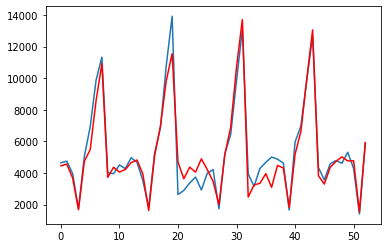

In [25]:
# Plot forecast against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [26]:
# Erros residuais
residuals = [test[i] - predictions[i] for i in range(len(test))]

In [27]:
# Convertendo a lista em um dataframe
residuals = pd.DataFrame( residuals)

In [28]:
# Imprime as 5 primeiras linhas
residuals.head()

,0
0,191.89
1,185.32
2,273.91
3,38.04
4,303.17


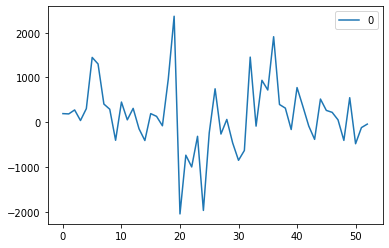

In [29]:
# Plot residuals
residuals.plot()
plt.show()

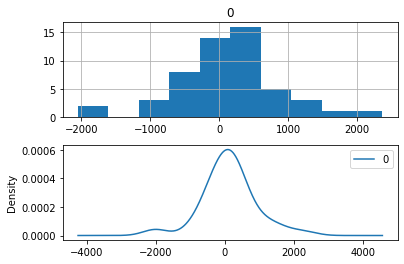

In [30]:
# Plots histograma
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())

plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

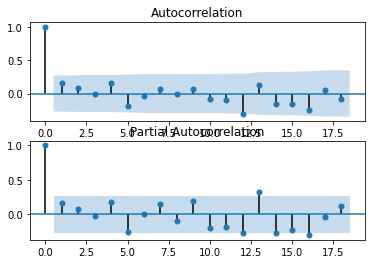

In [31]:
# Plots de autocorrelação
plt.figure()
plt.subplot(211)
plot_acf(residuals, ax=plt.gca())
plt.subplot(212)
plot_pacf(residuals, ax=plt.gca())
plt.show()

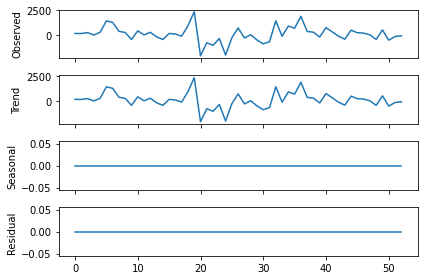

In [32]:
# Decompondo a série de erro residual

result = seasonal_decompose( residuals, model='additive', freq=1)
result.plot()
plt.show()